In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
n=500
P=2#自变量维度
m=3#三个亚组
weight=[0.2,0.4,0.4]
mean=[-2.5,0,3]
covs=[1,0.7,1]#标准差
Theta=np.array([weight,mean,covs])
Theta#混合高斯分布的参数，mean越靠近且离散程度越大，区分的难度越大
p1=int(n*weight[0])
p2=int(n*weight[1])
p3=int(n*weight[2])

In [4]:
np.random.seed(4)
mu=np.array([0,0])
cov=np.array([[2,0.5],[0.5,2]])
x=np.random.multivariate_normal(mu,cov,n,check_valid='raise')
betat=np.random.uniform(0,1,P)
betat

array([0.2964262 , 0.48595574])

In [5]:
np.random.seed(123)
aa=np.random.normal(mean[0],covs[0],p1)
bb=np.random.normal(mean[1],covs[1],p2)
cc=np.random.normal(mean[2],covs[2],p3)
gamma=np.zeros((n,2))#随机效应的具体取值，第二列为所属亚组
gamma[:,0]=np.hstack((aa,bb,cc))
gamma[:p1,1]=0
gamma[p1:p1+p2,1]=1
gamma[-p3:,1]=3

In [6]:
y=np.zeros((n,2))
for i in range(n):
        y[i,0]=np.dot(x[i],betat)+gamma[i,0]
        y[i,1]=gamma[i,1]

In [7]:
model = LinearRegression() # 构建线性模型
model.fit(x, y[:,0]) # 自变量在前，因变量在后
coef = model.coef_ # 斜率
intercept = model.intercept_ # 截距
print(betat,'\n',model.coef_, model.intercept_) # 输出斜率和截距

[0.2964262  0.48595574] 
 [0.38618445 0.48864925] 0.6784892176073899


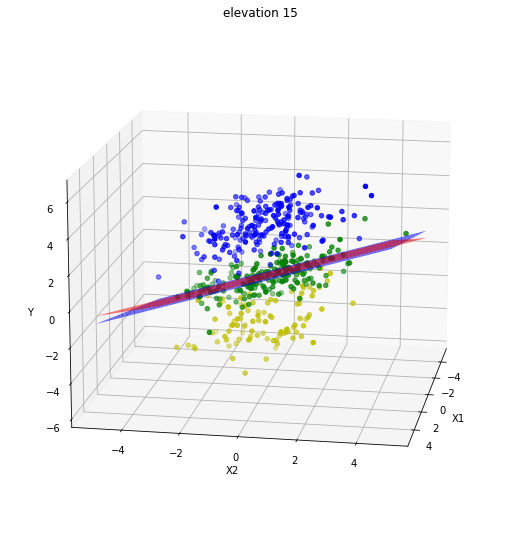

In [9]:
fig = plt.figure(figsize=(20,10))

xm = np.linspace(-5, 5,10)
ym = np.linspace(-5, 5,10)
X, Y = np.meshgrid(xm, ym)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,Z=betat[0]*X+betat[1]*Y, color='b',alpha=0.6,label='True beta')
ax1.plot_surface(X,Y,Z=coef[0]*X+coef[1]*Y, color='r',alpha=0.6,label='beta0')
ax1.scatter(x[:p1,0],x[:p1,1], y[:p1,0], c='y')  # 绘制数据点
ax1.scatter(x[p1:p1+p2,0],x[p1:p1+p2,1], y[p1:p1+p2,0], c='g')
ax1.scatter(x[-p3:,0],x[-p3:,1], y[-p3:,0], c='b')
ax1.set_zlabel('Y')  # 坐标轴
ax1.set_ylabel('X2')
ax1.set_xlabel('X1')
ax1.view_init(elev=30,    # 仰角
            azim=10)   # 方位角
ax1.set_title('elevation 20')

ax2 = fig.add_subplot(122, projection='3d')  # 创建一个三维的绘图工程度
ax2.scatter(x[:p1,0],x[:p1,1], y[:p1,0], c='y')  # 绘制数据点
ax2.scatter(x[p1:p1+p2,0],x[p1:p1+p2,1], y[p1:p1+p2,0], c='g')
ax2.scatter(x[-p3:,0],x[-p3:,1], y[-p3:,0], c='b')
ax2.plot_surface(X,Y,Z=betat[0]*X+betat[1]*Y, color='b',alpha=0.6)
ax2.plot_surface(X,Y,Z=coef[0]*X+coef[1]*Y, color='r',alpha=0.6)
ax2.set_zlabel('Y')  # 坐标轴
ax2.set_ylabel('X2')
ax2.set_xlabel('X1')
ax2.view_init(elev=15,    # 仰角
            azim=10)   # 方位角
ax2.set_title('elevation 15')

plt.show()

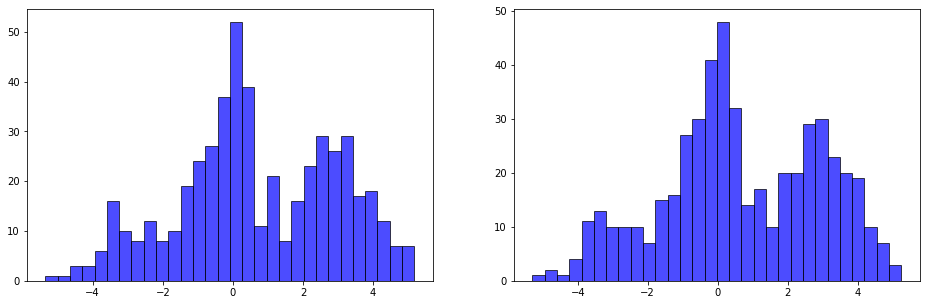

In [24]:
data0=np.zeros(n)
data1=np.zeros(n)
for i in range(n):
    data0[i]=y[i,0]-np.dot(x[i],coef)
    data1[i]=y[i,0]-np.dot(x[i],betat)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.hist(data0, bins=30,  facecolor="blue", edgecolor="black", alpha=0.7)
ax2 = fig.add_subplot(122)
ax2.hist(data1, bins=30,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

datat=np.zeros(n)
for i in range(n):
    datat[i]=y[i,0]-np.dot(x[i],betat)

In [25]:
smean=np.mean(data0)
sstd=np.std(data0)
ssvar=np.var(data0)
stheta0=np.array([smean,sstd])
stheta0#样本均值与样本的标准差

array([0.67848922, 2.24737698])

In [26]:
#假设通过某些方法得到一个较好的初值
beta0=coef
weight0=[0.3,0.4,0.3]
mean0=[-4,0,4]
covs0=[1,1,1]
theta0=np.array([weight0,mean0,covs0])

In [27]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

def mixnormal(x,theta):
    m=theta.shape[0]
    result=0
    for i in range(m):
        result+=theta[0,1]*normal(x,theta[1:,i])
    return result


def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

def Betanxt(betaold,thetaold,Xs,Y,t=1):#定义了一个联系两次牛顿法迭代的函数
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L=Lih(data,thetaold)

    firstorder=np.zeros(P)
    for p in range(P):
        a=0
        for h in range (m):
            for i in range(num):
                a += (((L[i,h])/(thetaold[2,h]**2))*((data[i]-thetaold[1,h]))*(Xs[i,p]))
        firstorder[p]=a

    secorder=np.zeros((P,P))
    for k in range(P):#这里为对称矩阵，其实可以加速
        for l in range(k,P):
            a=0
            for h in range (m):
                for i in range(n):
                    a += (((L[i,h])/(thetaold[2,h]**2))*((Xs[i,k])*(Xs[i,l])))
            secorder[k,l]=a
            secorder[l,k]=a

    invsecorder=np.linalg.inv(secorder)
    direction=np.dot(invsecorder,firstorder)
    λ2=np.dot(firstorder.T,direction)
    betanxt=betaold-t*direction
    return betanxt,λ2/2,t

def Betanxt(betanow,thetaold,Xs,Y,t=1):#定义了一个联系两次牛顿法迭代的函数
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betanow.T)
    L=Lih(data,thetaold)
    C=thetaold.shape[1]

    firstorder=np.zeros(P)
    for h in range (C):
        for i in range(num):
            firstorder += (((L[i,h])/(thetaold[2,h]**2))*((data[i]-thetaold[1,h]))*(Xs[i]))

    secorder=np.zeros((P,P))
    for k in range(P):#这里为对称矩阵
        for l in range(k,P):
            a=0
            for h in range (C):
                for i in range(n):
                    a += (((L[i,h])/(thetaold[2,h]**2))*((Xs[i,k])*(Xs[i,l])))
            secorder[k,l]=a
            secorder[l,k]=a

    invsecorder=np.linalg.inv(secorder)
    direction=np.dot(invsecorder,firstorder.T)
    λ2=np.dot(firstorder,direction)
    betanxt=betanow+t*direction
    return betanxt,λ2/2,t


def Betaout(betazero,thetazero,Xs,Y,t0=1.,ε=0.05,N=1000):#这里给了牛顿法一个循环上界N
    out=[betazero,100,t0]
    for i in range(N):
        out=Betanxt(out[0],thetazero,Xs,Y,out[2])
        if out[1]<=ε:
            break 
    return out,i+1

Betaout(beta0,theta0,x,y[:,0],t0=0.05,ε=0.01,N=1000)

beta11=np.array([0.81108023, 0.05820156])
beta00=np.zeros(P)
for i in range(n):
    for h in range(m):
        beta00+=(L0[i,h])/((theta0[2,h])**2)*(y[i,0]-np.dot(x[i],beta11)-(theta0[1,h]))*x[i]
beta00

beta111=np.array([0.74406456, 0.07559384])
beta01=np.zeros(P)
for i in range(n):
    for h in range(m):
        beta01+=(L0[i,h])/((theta0[2,h])**2)*(y[i,0]-np.dot(x[i],beta111)-(theta0[1,h]))*x[i]
beta01

L0=Lih(data0,theta0)
bi=np.zeros(n)
for i in range (n):
    for h in range(m):
        bi[i]+=(L0[i,h])/((theta0[2,h])**2)

ai=np.zeros(n)
for i in range (n):
    for h in range(m):
        ai[i]+=((L0[i,h])*((y[i,0]-theta0[1,h])))/((theta0[2,h])**2)

xnew=np.zeros((n,P))
for i in range(n):
    xnew[i]=x[i]*bi[i]

B=xnew.T
a1=np.dot(B,x)
a2=np.linalg.inv(a1)
a3=np.dot(a2,x.T)
a4=np.dot(a3,ai)
a4


In [28]:
def ECM(Xs,Y,betaold,thetaold,theta0,tp=0.25):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=thetaold.shape[1]
    d=np.zeros(C)
    thetanext=np.zeros((3,C))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)

    datanew=Y-np.dot(Xs,betanew.T)
    for k in range(C):#更新参数
        d[k]=np.sum(L0[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


def iterECM(Xs,Y,beta0,theta0,tp=0.25,N=1000,ε=0.005):
    T0=[beta0,theta0]
    for i in range(N):
        a=T0[0]
        T0=ECM(Xs,Y,T0[0],T0[1],theta0,tp)
        b=np.linalg.norm(T0[0]-a)
        '''
        if b<=ε:
            break
        '''
    return T0,b,i


def ECM(Xs,Y,betaold,thetaold,theta0,tp=0.25):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=thetaold.shape[1]
    d=np.zeros(C)
    thetanext=np.zeros((3,C))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((y[i,0]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(n):
        xnew[i]=x[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)
    datanew=Y-np.dot(Xs,betanew.T)
    L1=Lih(datanew,thetaold)

    for k in range(C):#更新参数
        d[k]=np.sum(L0[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(L1[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L1[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


def iterECM(Xs,Y,beta0,theta0,tp=0.25,N=1000,ε=0.005):
    T0=[beta0,theta0]
    for i in range(N):
        a=T0[0]
        T0=ECM(Xs,Y,T0[0],T0[1],theta0,tp)
        b=np.linalg.norm(T0[0]-a)
        '''
        if b<=ε:
            break
        '''
    return T0,b,i


In [29]:
beta0,theta0

(array([0.38618445, 0.48864925]),
 array([[ 0.3,  0.4,  0.3],
        [-4. ,  0. ,  4. ],
        [ 1. ,  1. ,  1. ]]))

In [30]:
betat,Theta

(array([0.2964262 , 0.48595574]),
 array([[ 0.2,  0.4,  0.4],
        [-2.5,  0. ,  3. ],
        [ 1. ,  0.7,  1. ]]))

In [35]:
iterECM(x,y[:,0],beta0,theta0,0.25,500)

((array([0.33379262, 0.44468872]),
  array([[ 0.1459192 ,  0.46102283,  0.39305797],
         [-2.97902864, -0.14464916,  2.97718354],
         [ 0.84887638,  0.75852584,  0.94402894]])),
 0.0,
 499)

def thetanxt(Xs,Y,thetaold,betaold,betanew,tp=0.25):
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    datanew=Y-np.dot(Xs,betanew.T)
    svar=np.std(datanew)
    Ga=Lih(data,thetaold)
    d=np.zeros(m)
    thetanew=np.zeros((3,m))

    for k in range(m):#更新参数
        d[k]=np.sum(Ga[:,k])
        thetanew[0,k]=d[k]/num
        thetanew[1,k]=np.dot(Ga[:,k],datanew[:])/d[k]
        thetanew[2,k]=np.sqrt((np.dot(Ga[:,k],(datanew[:]-thetanew[1,k])**2)+2*tp*svar)/(d[k]+2*tp))#标准差

def Q(thetaold,Xs,Y,betaold,betanew,tp=0.25):
    Q=0
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    datanew=Y-np.dot(Xs,betanew.T)
    svar=np.std(datanew)
    Ga=Lih(data,thetaold)
    d=np.zeros(m)
    thetanew=np.zeros((3,m))

    for k in range(m):#更新参数
        d[k]=np.sum(Ga[:,k])
        thetanew[0,k]=d[k]/num
        thetanew[1,k]=np.dot(Ga[:,k],datanew[:])/d[k]
        thetanew[2,k]=np.sqrt((np.dot(Ga[:,k],(datanew[:]-thetanew[1,k])**2)+2*tp*svar)/(d[k]+2*tp))#标准差

    '''
    for h in range(m):
        for i in range(num):
            Q+=(d[h]/num)*(np.log(thetanew[1,h]))+(Ga[i,h])*(np.log(normal(datanew[i],thetanew[1:,h])))-(tp/num)*ps(thetanew[2,h],svar,tp)
'''
    return thetanew
